# MedGemma4B Fine Tuning

Estudo de ajuste fino do MedGemma4B visando melhorar sua geração de respostas para radiografias em PT-BR.

Para esse estudo utilizei como referência o exemplo fornecido pela Google, [Notebook](https://colab.research.google.com/github/google-health/medgemma/blob/main/notebooks/fine_tune_with_hugging_face.ipynb#scrollTo=r-esHCwnQFye).

In [ ]:
! pip install --upgrade --quiet accelerate bitsandbytes transformers trl peft bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.4/556.4 kB 41.9 MB/s eta 0:00:00


In [ ]:
import os
import re
import gc
import json
import torch
import random
import shutil
from torch.utils.data import Dataset, DataLoader

from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig
from transformers import Trainer

from PIL import Image

from huggingface_hub import login

from tqdm import tqdm

from typing import List, Tuple, Any

from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from trl import SFTConfig, SFTTrainer

from google.colab import drive

import matplotlib.pyplot as plt

from IPython.display import Image as IPImage, display, Markdown

In [ ]:
login()

---
## Dados

Os dados devem ser separados por tipo como treino, validação e teste. E devem ser balanceados, ou seja, cada tipo deve conter uma quantidade semelhante de cada caso (ex: No finding, Edema, etc). O pré-processamento considero que já deva ser feito antes desse passo. Nesta etapa apenas iremos carregar os dados (que podem ser armazenados no Google Drive).

Montagem do Google Drive no ambiente do Colab

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Copiar arquivos para o ambiente do Colab

In [ ]:
# # caminho para repositório mini - apenas para testar funcionamento do notebook
# files_path = '/content/drive/MyDrive/2025_2S_IA368HH/Projeto Final/SubDataset - MIMIC-CXR/micro_dataset_mimic_balanced/version1'

In [ ]:
files_path = '/content/drive/MyDrive/2025_2S_IA368HH/Projeto Final/SubDataset - MIMIC-CXR/last_micro_dataset_mimic_balanced'

In [ ]:
%%time
# !cp -r '' /content/
if not os.path.exists("/content/Dataset"):
    shutil.copytree(files_path, "/content/Dataset")

CPU times: user 869 ms, sys: 1.55 s, total: 2.42 s
Wall time: 12min 29s


In [ ]:
# Caminhos para cada conjunto de itens dos arquivos importados
train_img_dir = r'/content/Dataset/train/images'
train_txt_dir = r'/content/Dataset/train/texts'
val_img_dir = r'/content/Dataset/validate/images'
val_txt_dir = r'/content/Dataset/validate/texts'

Funções para carregar imagens e textos

In [ ]:
def load_images_from_folder(folder:str) -> list[list]:
  ''' Load images from Colab environment files '''
  all_images = []

  for subfolder in sorted(os.listdir(folder)):
      subfolder_path = os.path.join(folder, subfolder)

      if not os.path.isdir(subfolder_path):
          continue

      sub_images = []
      for filename in sorted(os.listdir(subfolder_path)):
          path = os.path.join(subfolder_path, filename)
          try:
              img = Image.open(path)
              sub_images.append(img)
          except Exception as e:
              print(f"Error to load {path}: {e}")
      if sub_images:
          all_images.append(sub_images)

  return all_images

In [ ]:
def load_texts_from_folder(folder:str) -> list:
  ''' Load texts from Colab environment '''
  texts = []
  for filename in sorted(os.listdir(folder)):
      path = os.path.join(folder, filename)
      if filename.endswith(".txt"):
          with open(path, 'r', encoding='utf-8') as f:
              texts.append(f.read().strip())
  return texts

Separando os dados de cada tipo

In [ ]:
train_images = load_images_from_folder(train_img_dir)
train_texts  = load_texts_from_folder(train_txt_dir)
val_images   = load_images_from_folder(val_img_dir)
val_texts    = load_texts_from_folder(val_txt_dir)

In [ ]:
print(f"Train: {len(train_images)} imagens, {len(train_texts)} textos")
print(f"Val: {len(val_images)} imagens, {len(val_texts)} textos")

Train: 960 imagens, 960 textos
Val: 473 imagens, 473 textos


Verificando uma amostra dos dados

In [ ]:
n = random.randint(0, len(train_images)-1)

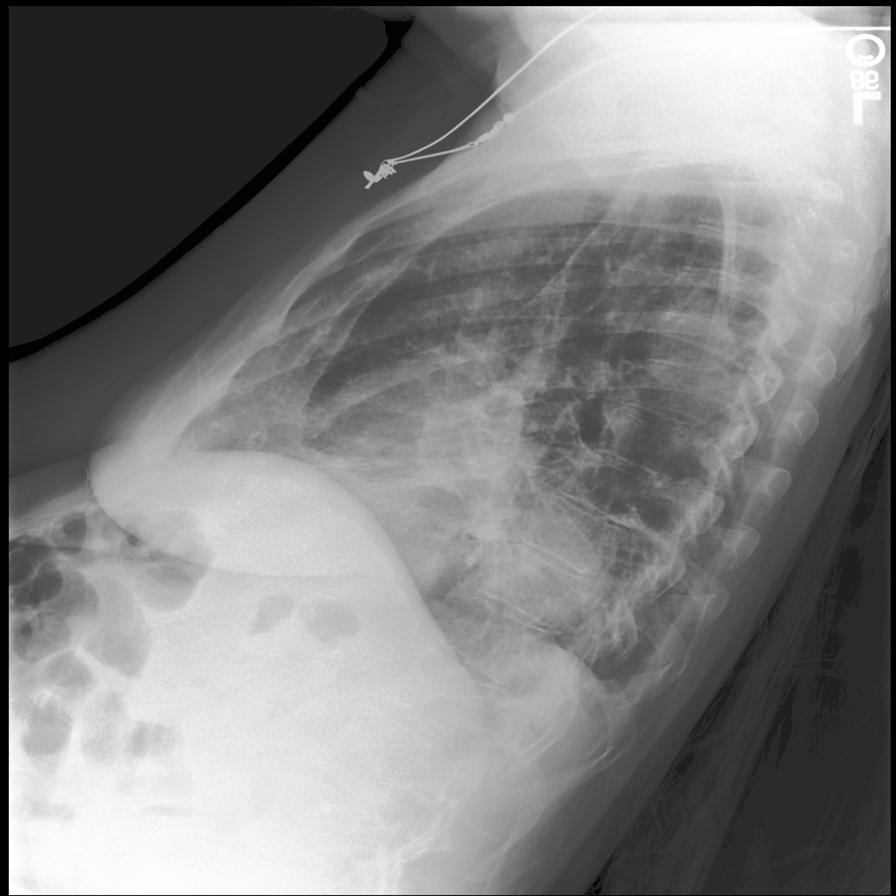

In [ ]:
display(train_images[n][0])

In [ ]:
Markdown(train_texts[n])

## Tradução do Relatório de Raio-X de Tórax

**RELATÓRIO FINAL**

**TÓRAX, DUAS INCIDÊNCIAS:** ___

**HISTÓRICO:** Paciente do sexo feminino, ___ anos, com tosse produtiva e calafrios.

**COMPARAÇÃO:** Radiografias de tórax de ___ e ___.

**ACHADOS:** Incidências frontal (PA) e perfil (lateral) do tórax. Identificam-se opacidades bibasais, semelhantes ao exame prévio. Observa-se um componente linear irregular na face lateral da base pulmonar esquerda, mais proeminente do que no exame anterior. Superiormente, os pulmões estão livres. Não há congestão vascular pulmonar. Há provável presença de pequenas efusões pleurais bilaterais, dada a obliteração dos ângulos costofrênicos posteriores. A silhueta cardiomediastínica está inalterada, com notável cardiomegalia leve. Não se detecta anormalidade óssea aguda.

**IMPRESSÃO:** Opacidades bibasais, com opacidades lineares mais proeminentes na base pulmonar esquerda. Os achados podem ser decorrentes de pneumonia. Recomenda-se repetir o exame após tratamento para documentar a resolução dos achados.

---

**Observações:**

*   Os espaços em branco (___) indicam informações que não foram fornecidas no relatório original (idade da paciente, datas dos exames anteriores).
*   "Ptiot" parece ser um erro de digitação para "prior" (anterior).
*   "Trace bilateral effusions" foi traduzido como "pequenas efusões pleurais bilaterais" para melhor clareza em português.
*   "Blunting of the posterior costophrenic angles" foi traduzido como "obliteração dos ângulos costofrênicos posteriores", que é a descrição radiológica correspondente.
*   "Cardiomediastinal silhouette" foi traduzido como "silhueta cardiomediastínica".
*   "Osseous abnormality" foi traduzido como "anormalidade óssea".
*   "Resolution of the findings" foi traduzido como "resolução dos achados".

---
## Processador dos dados

Modelo do Processador

In [ ]:
model_id = 'google/medgemma-4b-it'

Inicialização

In [ ]:
# Inicialização do processador de dados do MedGemma4B
# (esse é o modelo usado no Colab de exemplo da Google)
processor_4b = AutoProcessor.from_pretrained(model_id)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Sugestão no notebook da Google - usar padding no final das sequências de texto.

In [ ]:
# Use right padding to avoid issues during training
processor_4b.tokenizer.padding_side = "right"

---
## Dataset

Para o dataset teremos a separação das imagens e dos textos esperados na saída (target). A formatação da mensagem será feito apenas no getitem.

In [ ]:
class ImageAndStudyDataset(Dataset):
    """
    A PyTorch dataset that groups multiple radiology images from the same study
    together with their corresponding medical report, formatting the output in
    the multimodal chat structure required by MedGemma4B.

    Each dataset entry represents a single radiology study and provides:
      - images: a list of PIL.Image objects belonging to the study
      - label: the ground-truth medical report associated with that study
      - messages: a chat-style multimodal prompt containing:
            * one {"type": "image"} entry for each image
            * a system/user text prompt
            * the medical report as the assistant response

    The dataset expects the following directory structure:
        files_path/
            images/
                study_001/
                    img1.png
                    img2.png
                    ...
                study_002/
                    ...
            texts/
                report_001.txt
                report_002.txt
                ...

    Input:
      - files_path (str): base directory containing 'images/' and 'texts/'.
      - sys_prompt (str): text instruction included in the user message.

    Output (per item):
      A dictionary with:
        {
            'image': [PIL.Image, ...],
            'label': <string medical report>,
            'messages': <multimodal chat prompt>
        }
    """

    def __init__(
        self,
        images,
        texts,
        sys_prompt: str = "Apresente o diagnóstico das imagens de radiografia, em português brasileiro",
        filter_text:bool=True,
        lim_images:bool=True
    ):
        """

        """
        self.images = images
        self.reports = texts
        self.sys_prompt = sys_prompt
        self.filter_text = filter_text
        self.lim_images = lim_images

    # def load_texts_from_folder(self, folder:str) -> list:
    #     ''' Load texts from Colab environment '''
    #     texts = []
    #     for filename in sorted(os.listdir(folder)):
    #         path = os.path.join(folder, filename)
    #         if filename.endswith(".txt"):
    #             with open(path, 'r', encoding='utf-8') as f:
    #                 texts.append(f.read().strip())
    #     return texts

    # def load_images_from_folder(self, folder:str) -> list[list]:
    #     ''' Load images from Colab environment files '''
    #     all_images = []

    #     for subfolder in sorted(os.listdir(folder)):
    #         subfolder_path = os.path.join(folder, subfolder)

    #         if not os.path.isdir(subfolder_path):
    #             continue

    #         sub_images = []
    #         for filename in sorted(os.listdir(subfolder_path)):
    #             path = os.path.join(subfolder_path, filename)
    #             try:
    #                 img = Image.open(path)
    #                 sub_images.append(img)
    #             except Exception as e:
    #                 print(f"Error to load {path}: {e}")
    #         if sub_images:
    #             all_images.append(sub_images)

    #     return all_images

    def text_filter(self, text: str) -> str:
        """
        Extracts the ACHADOS + IMPRESSÃO sections from a medical report
        and removes markdown markers (**, ---) and section headers.
        """

        text_lower = text.lower()

        # Locate "ACHADOS"
        match_findings = re.search(r'\bachados\b\s*:', text_lower)
        if not match_findings:
            return ""

        start = match_findings.end()

        # Locate "OBSERVAÇÕES" to use as stopping point
        match_observations = re.search(r'\bobserva[cç][oõ]es\b\s*:', text_lower)
        end = match_observations.start() if match_observations else len(text)

        # Extract the raw content between ACHADOS and OBSERVAÇÕES
        extracted = text[start:end].strip()

        # Patterns to clean markdown symbols and section titles
        cleanup_patterns = [
            r"\*\*",                    # remove ** markdown
            r"^achados\s*:\s*",         # remove 'ACHADOS:'
            r"^impress[aã]o\s*:\s*",    # remove 'IMPRESSÃO:'
            r"---",                     # remove horizontal rule
        ]

        for pattern in cleanup_patterns:
            extracted = re.sub(pattern, "", extracted, flags=re.IGNORECASE | re.MULTILINE)

        # Normalize extra blank lines
        extracted = re.sub(r"\n\s*\n+", "\n\n", extracted).strip()

        return extracted

    def __getitem__(self, idx):
        """
        Returns a single dataset item formatted according to the
        multimodal format expected by the MedGemma processor.

        The "messages" structure follows this logic:
            - Each image is represented as {"type": "image"}.
            - After all images, the system/user prompt is added as text.
            - The medical report is provided as the assistant's response.
        """

        report = self.reports[idx]
        if self.filter_text:
            report = self.text_filter(report)

        # Create one {"type": "image"} entry for each image in the study
        images = self.images[idx]
        type_images = [{'type': 'image'} for _ in range(len(images))]
        # limit the number of images (max: 2 images)
        if self.lim_images:
            images = images[:2]
            type_images = type_images[:2]

        return {
            'image': images,   # list of PIL images for this study
            'label': report,   # ground-truth medical report
            'messages': [
                {
                    "role": "user",
                    "content": type_images + [
                        {'type': 'text', 'text': self.sys_prompt}
                    ],
                },
                {
                    "role": "assistant",
                    "content": [
                        {'type': 'text', 'text': report},
                    ],
                }
            ]
        }

    def __len__(self):
        """Returns the number of radiology studies in the dataset."""
        return len(self.images)

In [ ]:
# class ImageAndStudyDataset(Dataset):
#     """
#     Dataset for training MedGemma4B,combining multiple images from a single
#     radiology study with the corresponding medical report.

#     Each dataset item contains:
#       - images: list of PIL images belonging to the same study
#       - label: the ground-truth radiology report
#       - messages: a chat-style structure (role/content) used by the processor
#                   to generate a multimodal prompt with N images + text.
#     """

#     def __init__(
#         self,
#         images: list[list],
#         reports: list[str],
#         sys_prompt: str = "Apresente o diagnóstico das imagens de radiografia, em português brasileiro"
#     ):
#         """
#         Args:
#             images (list[list[PIL.Image]]):
#                 A list where each element corresponds to one radiology study.
#                 Each study contains a list of one or more PIL images.

#             reports (list[str]):
#                 A list of textual medical reports that match the image groups.

#             sys_prompt (str):
#                 Instruction text appended after all image tokens in the prompt.
#                 This is shown as the user input before the model generates a response.
#         """
#         self.images = images
#         self.reports = reports
#         self.sys_prompt = sys_prompt

#     def __getitem__(self, idx):
#         """
#         Returns a single dataset item formatted according to the
#         multimodal format expected by the MedGemma processor.

#         The "messages" structure follows this logic:
#             - Each image is represented as {"type": "image"}.
#             - After all images, the system/user prompt is added as text.
#             - The medical report is provided as the assistant's response.
#         """
#         images = self.images[idx]
#         report = self.reports[idx]

#         # Create one {"type": "image"} entry for each image in the study
#         type_images = [{'type': 'image'} for _ in range(len(images))]

#         return {
#             'image': images,   # list of PIL images for this study
#             'label': report,   # ground-truth medical report
#             'messages': [
#                 {
#                     "role": "user",
#                     "content": type_images + [
#                         {'type': 'text', 'text': self.sys_prompt}
#                     ],
#                 },
#                 {
#                     "role": "assistant",
#                     "content": [
#                         {'type': 'text', 'text': report},
#                     ],
#                 }
#             ]
#         }

#     def __len__(self):
#         """Returns the number of radiology studies in the dataset."""
#         return len(self.images)


In [ ]:
train_dataset = ImageAndStudyDataset(train_images, train_texts)
val_dataset = ImageAndStudyDataset(val_images, val_texts)

Verificando uma amostra do dataset

In [ ]:
output = train_dataset[random.randint(0, len(train_dataset)-1)]

In [ ]:
type(train_dataset)

__main__.ImageAndStudyDataset

In [ ]:
text = output['label']
images = output['image']
message = output['messages']

In [ ]:
type(images), type(text), type(message)

(list, str, list)

In [ ]:
output

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=896x896>],
 'label': 'Raio-x de tórax portátil AP (vista única) mostra sonda de Dobbhoff com a ponta terminando na cavidade gástrica média. Opacidade na base do pulmão esquerdo piorou desde o raio-x anterior devido ao aumento do derrame pleural e colapso do lobo inferior esquerdo. No contexto clínico apropriado, pneumonia deve ser considerada. Pulmão direito está claro, sem consolidação, nódulos ou derrame pleural. Não há pneumotórax. O tamanho do coração está parcialmente obscurecido pelo derrame pleural esquerdo, mas parece dentro dos limites normais.\n\nPosicionamento correto da sonda de Dobbhoff terminando na cavidade gástrica média. Aumento intervalar do colapso da base pulmonar esquerda e derrame pleural, preocupante para pneumonia.',
 'messages': [{'role': 'user',
   'content': [{'type': 'image'},
    {'type': 'text',
     'text': 'Apresente o diagnóstico das imagens de radiografia, em português brasileiro'}]},
  

In [ ]:
text

'Raio-x de tórax portátil AP (vista única) mostra sonda de Dobbhoff com a ponta terminando na cavidade gástrica média. Opacidade na base do pulmão esquerdo piorou desde o raio-x anterior devido ao aumento do derrame pleural e colapso do lobo inferior esquerdo. No contexto clínico apropriado, pneumonia deve ser considerada. Pulmão direito está claro, sem consolidação, nódulos ou derrame pleural. Não há pneumotórax. O tamanho do coração está parcialmente obscurecido pelo derrame pleural esquerdo, mas parece dentro dos limites normais.\n\nPosicionamento correto da sonda de Dobbhoff terminando na cavidade gástrica média. Aumento intervalar do colapso da base pulmonar esquerda e derrame pleural, preocupante para pneumonia.'

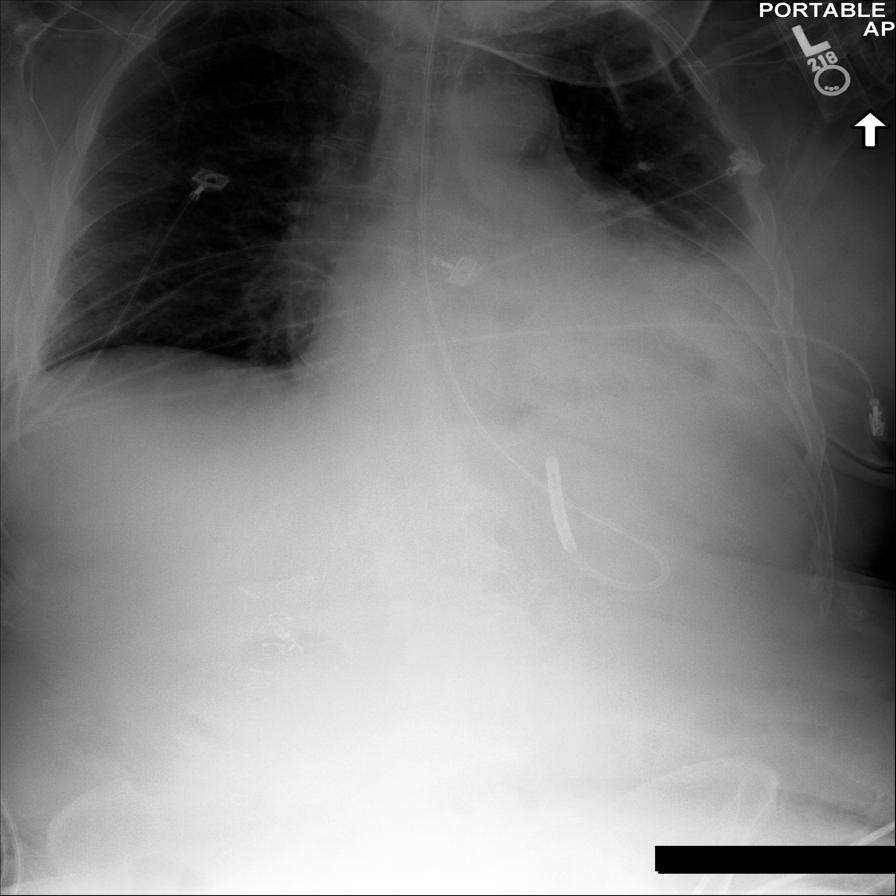

In [ ]:
display(*images)

In [ ]:
message

[{'role': 'user',
  'content': [{'type': 'image'},
   {'type': 'text',
    'text': 'Apresente o diagnóstico das imagens de radiografia, em português brasileiro'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'Raio-x de tórax portátil AP (vista única) mostra sonda de Dobbhoff com a ponta terminando na cavidade gástrica média. Opacidade na base do pulmão esquerdo piorou desde o raio-x anterior devido ao aumento do derrame pleural e colapso do lobo inferior esquerdo. No contexto clínico apropriado, pneumonia deve ser considerada. Pulmão direito está claro, sem consolidação, nódulos ou derrame pleural. Não há pneumotórax. O tamanho do coração está parcialmente obscurecido pelo derrame pleural esquerdo, mas parece dentro dos limites normais.\n\nPosicionamento correto da sonda de Dobbhoff terminando na cavidade gástrica média. Aumento intervalar do colapso da base pulmonar esquerda e derrame pleural, preocupante para pneumonia.'}]}]

---
## Amostrador


In [ ]:
def medgemma_collate_fn(examples: list[dict[str, Any]], processor=processor_4b):
    """
    Custom collate function for preparing multimodal batches for Med-Gemma 4B.

    This function:
    - Extracts text messages and images from each example.
    - Applies the chat template to convert message dictionaries into textual prompts.
    - Uses the MedGemma processor to tokenize text and preprocess images.
    - Creates label tensors for supervised training.
    - Masks out special tokens such as padding, image placeholder tokens,
      and specific unused tokens so they do not contribute to the loss.

    Args:
        examples (list[dict]): A list of dataset samples. Each sample is expected to contain:
            - "image": a list of images corresponding to the example.
            - "messages": a list of dictionaries representing a chat-like conversation.
        processor: MedGemma processor responsible for tokenization and image preprocessing.

    Returns:
        dict: A batch dictionary containing:
            - "input_ids": tokenized text
            - "pixel_values": processed image tensors
            - "attention_mask": attention mask for text
            - "labels": training labels with ignored positions masked to -100
    """
    texts = []
    images = []

    # Iterate over the batch and extract text prompts and images
    for example in examples:
        # Append the image list to the images array (each example contains a list of images)
        images.append(example['image'])

        # Convert the chat-style message into a plain text prompt (no tokenization yet)
        texts.append(processor.apply_chat_template(
            example["messages"], add_generation_prompt=False, tokenize=False
        ).strip())

    # Use the processor to tokenize the texts and preprocess the images
    # padding=True ensures that text sequences are padded to the same length
    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    # Clone input IDs to create labels for supervised training
    labels = batch["input_ids"].clone()

    # Get token ID corresponding to the <image> placeholder token
    image_token_id = [
        processor.tokenizer.convert_tokens_to_ids(
            processor.tokenizer.special_tokens_map["boi_token"]
        )
    ]

    # Ignore padded tokens in the loss
    labels[labels == processor.tokenizer.pad_token_id] = -100

    # Ignore special image placeholder tokens in the loss
    labels[labels == image_token_id] = -100

    # Ignore an additional special token (specific to the MedGemma4B tokenizer)
    labels[labels == 262144] = -100

    # Add labels to the batch
    batch["labels"] = labels
    return batch


Verificando a função medgemma_collate_fn

In [ ]:
sample_batch = [train_dataset[i] for i in range(2)]

In [ ]:
sample_batch[0]

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=896x896>],
 'label': '',
 'messages': [{'role': 'user',
   'content': [{'type': 'image'},
    {'type': 'text',
     'text': 'Apresente o diagnóstico das imagens de radiografia, em português brasileiro'}]},
  {'role': 'assistant', 'content': [{'type': 'text', 'text': ''}]}]}

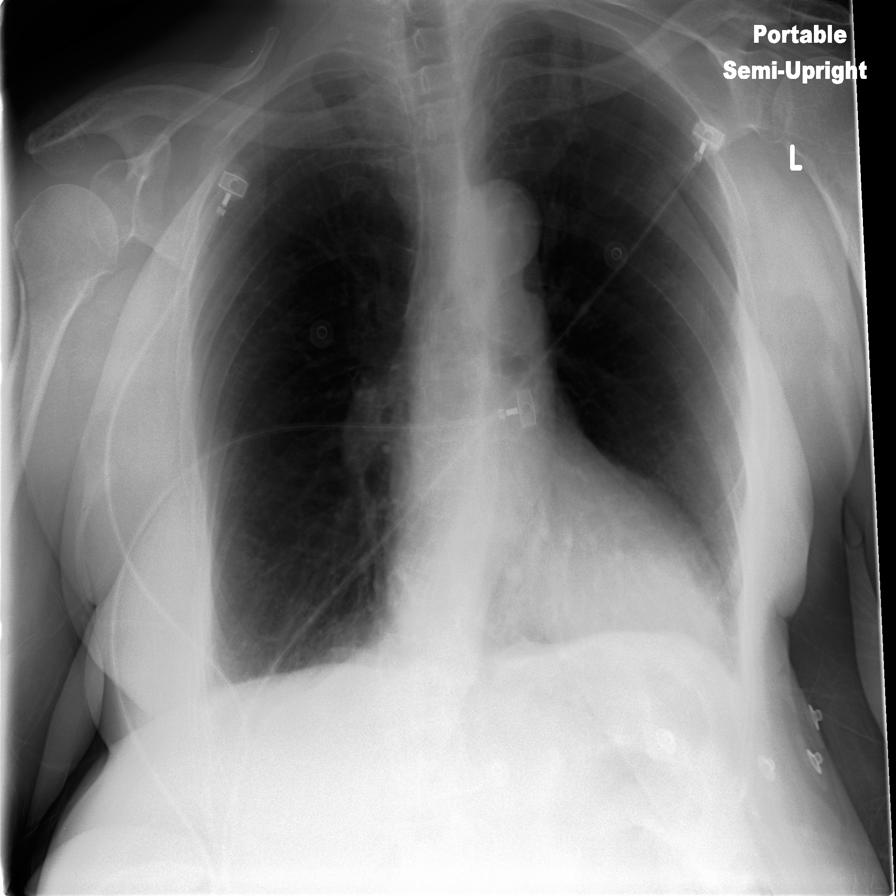

In [ ]:
display(*sample_batch[0]['image'])

In [ ]:
batch_output = medgemma_collate_fn(sample_batch)

In [ ]:
for k, v in batch_output.items():
    if torch.is_tensor(v):
        print(f"{k}: {v.dtype}")

input_ids: torch.int64
attention_mask: torch.int64
token_type_ids: torch.int64
pixel_values: torch.float32
labels: torch.int64


IMPORTANTE : Temos que passar as imagens para torch.bfloat16

In [ ]:
# print(batch_output.keys())
print(batch_output["input_ids"].shape)
print(batch_output["attention_mask"].shape)
print(batch_output["token_type_ids"].shape)
print(batch_output["pixel_values"].shape)
print(batch_output["labels"].shape)

torch.Size([2, 542])
torch.Size([2, 542])
torch.Size([2, 542])
torch.Size([2, 3, 896, 896])
torch.Size([2, 542])


---
## Verificação do Hardware

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Ponto importante para verificar sobre capacidade do Hardware (caso não possua VRAM suficiente o modelo não consegue ser carregado)

In [ ]:
# Check if GPU supports bfloat16
if torch.cuda.get_device_capability()[0] < 8:
    raise ValueError("GPU does not support bfloat16, please use a GPU that supports bfloat16.")

---
## QLoRA - processo manual

Nesta etapa será configurado os parâmetros para o LoRA e quantização. A parte de treinamento será feito por uma função construída abaixo.

### Preparação do Modelo com QLoRA

In [ ]:
model_kwargs = dict(
    attn_implementation="eager",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

#### Quantização

In [ ]:
model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4", # normal float 4 - default QLoRA
    bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
    bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
)

#### Inicialização do Modelo

In [ ]:
model_4b = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)

config.json:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

#### Parâmetros para LoRA

Seleção das camadas para aplicação do LoRA

In [ ]:
LORA_TARGET = ["q_proj", "k_proj", "v_proj", "o_proj"]

In [ ]:
lora_config = LoraConfig(
    r=16,                         # rank do adaptador
    lora_alpha=32,                # escala
    target_modules=LORA_TARGET,
    lora_dropout=0.05,            # dropout
    bias="none",                  # Sem bias
    task_type="CAUSAL_LM"         # causal LM (mesmo multimodal)
)

#### Aplicação do LoRA e congelamento de algumas camadas

In [ ]:
# # Caso queira resetar o modelo execute os comandos abaixo antes
# del model
# gc.collect()
# torch.cuda.empty_cache()
# print(f"Memória usada: {torch.cuda.memory_allocated()/1e9:.2f} GB")
# print(f"Memória reservada: {torch.cuda.memory_reserved()/1e9:.2f} GB")

Memória usada: 4.94 GB
Memória reservada: 9.53 GB


In [ ]:
# aplicando LoRA
model = get_peft_model(model_4b, lora_config)
model.print_trainable_parameters()

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


trainable params: 11,898,880 || all params: 4,311,978,352 || trainable%: 0.2759


Congelando parte Visual do modelo - como pretendo melhorar sua geração de texto, logo, não precisamos atualizar as camadas relacionadas à imagens.

In [ ]:
for name, param in model.vision_tower.named_parameters():
    param.requires_grad = False

PROBLEMA : Ao tentar fazer o backpropagation ocorria um erro relacionado à gradient checkpoint. Como recomendação do ChatGPT temos que desabilitar o gradient checkpointing e uso de cache.

In [ ]:
model.gradient_checkpointing_disable()

In [ ]:
model.config.use_cache = False

Quantidade de parâmetros treináveis

In [ ]:
# Parâmetros treináveis
model.print_trainable_parameters()

trainable params: 8,912,896 || all params: 4,311,978,352 || trainable%: 0.2067


### Hyperparameters

In [ ]:
LEARNING_RATE = 2e-4

In [ ]:
EPOCH = 1 # poucas épocas apenas para testar se executa sem acusar erros

#### Verificando funcionamento - se os dados inseridos no modelo são aceitos e se consegue calcular a Loss

In [ ]:
model.eval()
with torch.no_grad():
  batch_output = {k: v.to(device) if torch.is_tensor(v) else v for k, v in batch_output.items()}
  outputs = model(**batch_output)

In [ ]:
print(f'Loss: {outputs.loss.item():.2f}')

Loss: 17.93


### Treinamento

Durante o treinamento temos que a VRAM chega próxima à 36GB.

In [ ]:
# # Otimizador
# optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [ ]:
def fine_tuning_process(
    model,
    train_loader,
    val_loader,
    learning_rate=5e-5,
    epochs=3,
    model_name_saved="medgemma4b_adjusted"
):
  """
    Fine Tuning do MedGemma4B

    Args:
        model: modelo PyTorch (ex: AutoModelForImageTextToText)
        train_loader: DataLoader com os dados de treino
        val_loader: DataLoader com os dados de validação
        learning_rate (float): taxa de aprendizado utilizada no AdamW
        epochs (int): número de épocas
        model_name_saved (str): caminho/identificador para salvar o melhor modelo

    Returns:
        train_losses (list): perdas médias de treino por época
        val_losses (list): perdas médias de validação por época
  """

  device = next(model.parameters()).device
  train_losses, val_losses = [], []
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

  best_val_loss = float("inf")

  for epoch in range(epochs):
      # ======== TREINAMENTO ========
      model.train()
      total_train_loss = 0
      pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

      for batch in pbar:
          batch = {
              k: (
                  v.to(device, dtype=torch.bfloat16) if k == "pixel_values"
                  else v.to(device, dtype=torch.long)
              ) if torch.is_tensor(v) else v
              for k, v in batch.items()
          }

          outputs = model(**batch)
          loss = outputs.loss

          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

          total_train_loss += loss.item()
          pbar.set_postfix({"train_loss": loss.item()})

      avg_train_loss = total_train_loss / len(train_loader)
      train_losses.append(avg_train_loss)

      # ======== VALIDAÇÃO ========
      model.eval()
      total_val_loss = 0
      with torch.no_grad():
          for batch in val_loader:
              batch = {
                  k: (
                      v.to(device, dtype=torch.bfloat16) if k == "pixel_values"
                      else v.to(device, dtype=torch.long)
                  ) if torch.is_tensor(v) else v
                  for k, v in batch.items()
              }

              outputs = model(**batch)
              total_val_loss += outputs.loss.item()

      avg_val_loss = total_val_loss / len(val_loader)
      val_losses.append(avg_val_loss)

      print(f"\nEpoch {epoch+1}: train_loss={avg_train_loss:.4f}, val_loss={avg_val_loss:.4f}")

      # ======== SALVAR MELHOR MODELO ========
      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          model.save_pretrained(model_name_saved) # salvo modelo completo (com QLoRA)
          print(f"Novo melhor modelo salvo em '{model_name_saved}' (val_loss={best_val_loss:.4f})")
      else:
          print("Nenhuma melhoria na validação nesta época.")

  print(f"\nTreinamento finalizado! Melhor val_loss = {best_val_loss:.4f}")
  return train_losses, val_losses

In [ ]:
train_losses, val_losses = fine_tuning_process(model)

Epoch 1/1:   0%|          | 0/70 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2779: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Epoch 1/1: 100%|██████████| 70/70 [01:29<00:00,  1.27s/it, train_loss=2.78]



Epoch 1: train_loss=4.5676, val_loss=2.7737

Modelo salvo em: medgemma4b_adjusted


#### Plot dos resultados

In [ ]:
def plot_losses(train_losses:list=train_losses, val_losses:list=val_losses):
  epochs = range(1, len(train_losses) + 1)

  fig, axes = plt.subplots(1, 2, figsize=(12, 4))

  axes[0].plot(epochs, train_losses, marker='o', label='Train Loss', color='royalblue')
  axes[0].set_title("Training Loss")
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Loss")
  axes[0].grid(True, linestyle='--', alpha=0.5)
  axes[0].legend()

  axes[1].plot(epochs, val_losses, marker='s', label='Validation Loss', color='tomato')
  axes[1].set_title("Validation Loss")
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Loss")
  axes[1].grid(True, linestyle='--', alpha=0.5)
  axes[1].legend()

  plt.tight_layout()
  plt.show()

#### Para carregar o modelo e utilizá-lo

In [ ]:
processor = AutoProcessor.from_pretrained("medgemma4b_adjusted")
model = AutoModelForImageTextToText.from_pretrained(
    "medgemma4b_adjusted",
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

---
## QLoRA - Google Example

Tentativa de QLoRA utilizando o notebook exemplo da Google.

#### Configuração do modelo multimodal

In [ ]:
model_kwargs = dict(
    attn_implementation="eager",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

In [ ]:
model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
    bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
)

In [ ]:
model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)

config.json:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

In [ ]:
# Use right padding to avoid issues during training
processor_4b.tokenizer.padding_side = "right"

#### Configuração do LoRA

In [ ]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM",
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

In [ ]:
num_train_epochs = 1  # @param {type: "number"}
learning_rate = 2e-4  # @param {type: "number"}

#### Argumentos

In [ ]:
save_path = r'/content/drive/MyDrive/2025_2S_IA368HH/Projeto Final/Colabs/medgemma-4b-it-lora1'

In [ ]:
args = SFTConfig(
    output_dir=save_path,                                    # Directory and Hub repository id to save the model to
    num_train_epochs=num_train_epochs,                       # Number of training epochs
    per_device_train_batch_size=1,                           # Batch size per device during training
    per_device_eval_batch_size=1,                            # Batch size per device during evaluation
    gradient_accumulation_steps=16,                          # Number of steps before performing a backward/update pass
    gradient_checkpointing=True,                             # Enable gradient checkpointing to reduce memory usage
    optim="adamw_torch_fused",                               # Use fused AdamW optimizer for better performance
    logging_steps=1,                                         # Number of steps between logs
    save_strategy="epoch",                                   # Save checkpoint every epoch
    eval_strategy="steps",                                   # Evaluate every `eval_steps`
    eval_steps=1,                                            # Number of steps between evaluations
    learning_rate=learning_rate,                             # Learning rate based on QLoRA paper
    bf16=True,                                               # Use bfloat16 precision
    max_grad_norm=0.3,                                       # Max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                                       # Warmup ratio based on QLoRA paper
    lr_scheduler_type="linear",                              # Use linear learning rate scheduler
    push_to_hub=False,                                       # Push model to Hub (NÃO PRECISA SER ENVIADO PARA O HUGGING FACE)
    report_to="tensorboard",                                 # Report metrics to tensorboard
    gradient_checkpointing_kwargs={"use_reentrant": False},  # Set gradient checkpointing to non-reentrant to avoid issues
    dataset_kwargs={"skip_prepare_dataset": True},           # Skip default dataset preparation to preprocess manually
    remove_unused_columns = False,                           # Columns are unused for training but needed for data collator
    label_names=["labels"],                                  # Input keys that correspond to the labels
)

In [ ]:
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    peft_config=peft_config,
    data_collator=medgemma_collate_fn,
)

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:72: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:1222: UserWarning: Model has `tie_word_embeddings=True` and a tied layer is part of the adapter, but `ensure_weight_tying` is not set to True. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. Check the discussion here: https://github.com/huggingface/peft/issues/2777
  warnings.warn(msg)


In [ ]:
%%time
trainer.train()